## Определение возраста покупателей

### Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

labels.info()
labels.head()

Found 7591 validated image filenames.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Данные содержат менее 8 тысяч картинок. В файле две колонки - название файла и возраст человека на фотографии.

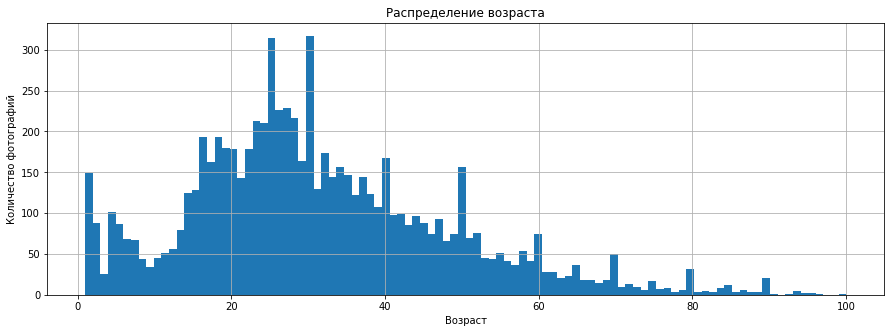

In [2]:
labels['real_age'].plot(grid=True, kind='hist', title='Распределение возраста', bins=100, figsize=(15,5))
plt.ylabel('Количество фотографий')
plt.xlabel('Возраст')
plt.show()

Выведем первые 15 фотографий для примера.

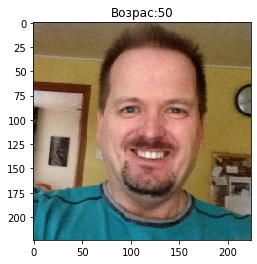

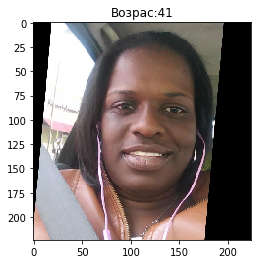

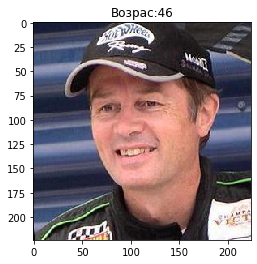

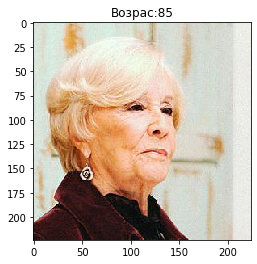

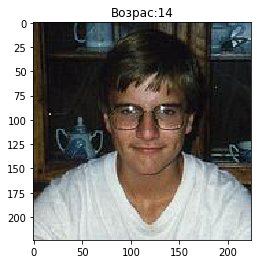

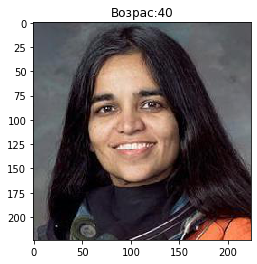

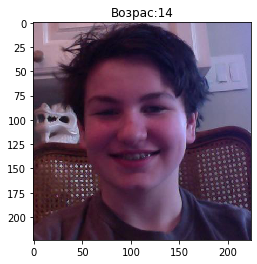

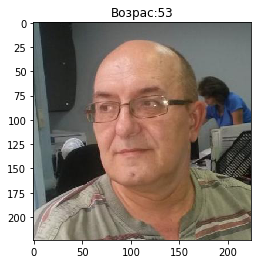

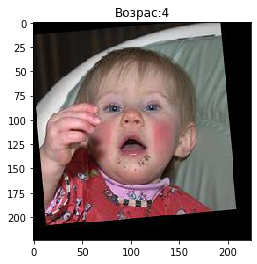

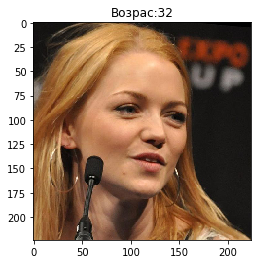

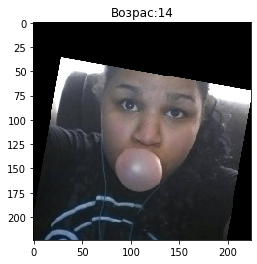

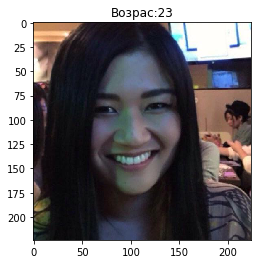

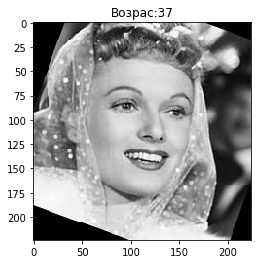

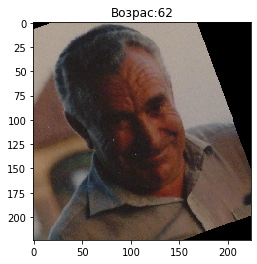

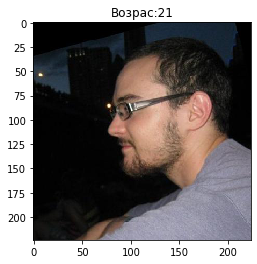

In [3]:
features, target = next(train_gen_flow)
for i in range(15):
    plt.imshow(features[i])
    plt.title('Возрас:{}'.format(target[i]))
    plt.show()

В выборке больше всего фотографий людей в возрасте примерно от 12 до 40 лет, поэтому ответы модели в этой возрастной группе будут более точными.

    
Повёрнуты все одинаково - вертикально. Фон произвольный, иногда видно, что изображение было выровнено.


### Обучение модели

В этом разделе код запускался отдельно, поэтому оформлен в текстовой ячейке.

```python

import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):

    datagen = ImageDataGenerator(rescale=1/255, validation_split=0.25)
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow


def load_test(path):

    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(rescale=1/255, validation_split=0.25)

    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())

    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 112s - loss: 197.2404 - mae: 10.3683 - val_loss: 909.3736 - val_mae: 25.3275
Epoch 2/10
178/178 - 41s - loss: 100.8416 - mae: 7.5944 - val_loss: 629.4074 - val_mae: 20.0362
Epoch 3/10
178/178 - 41s - loss: 66.1339 - mae: 6.2027 - val_loss: 792.0473 - val_mae: 23.1992
Epoch 4/10
178/178 - 39s - loss: 45.8804 - mae: 5.2541 - val_loss: 156.3294 - val_mae: 9.1840
Epoch 5/10
178/178 - 39s - loss: 30.2506 - mae: 4.2405 - val_loss: 93.2375 - val_mae: 7.2799
Epoch 6/10
178/178 - 39s - loss: 20.5443 - mae: 3.5039 - val_loss: 76.6235 - val_mae: 6.6308
Epoch 7/10
178/178 - 39s - loss: 14.4690 - mae: 2.9494 - val_loss: 75.8843 - val_mae: 6.5433
Epoch 8/10
178/178 - 39s - loss: 12.6649 - mae: 2.7206 - val_loss: 70.7199 - val_mae: 6.4813
Epoch 9/10
178/178 - 39s - loss: 10.1177 - mae: 2.4256 - val_loss: 73.9880 - val_mae: 6.4991
Epoch 10/10
178/178 - 39s - loss: 8.5931 - mae: 2.2335 - val_loss: 72.3350 - val_mae: 6.4048
60/60 - 10s - loss: 72.3350 - mae: 6.4048
Test MAE: 6.4048


```

### Анализ обученной модели

Разделили данные на воборке в соотношении 75:25

Для обучения хватило 10 эпох, а размер батча пришлось увеличить до 32.

Итоговое значение MAE получилось 6.4

Думаю, что модель позволяет решить поставленные бизнесом задачи, т.к. итоговое значение МАЕ ниже, чем 8 по условию.